In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno

from sklearn import linear_model
from sklearn.model_selection import train_test_split
import pickle

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

In [8]:
df = pd.read_csv('../data/raw/triathlon_watch_training_data_final.csv')
#count missing values
df.isnull().sum()


ID                               22
Age of customer                  22
Sex                              22
Ctry                             22
Town                             61
Swimming Hours per Week          22
Biking Hours per Week            46
Running Hours per Week           22
Total Training Hours per Week    22
VO2 Max                          25
10k Running Time Prediction      22
Calories Burned per Week         41
Support Cases of Customer        22
Customer Years                   22
Most current software update     23
Goal of Training                 50
Preferred Training Daytime       46
Subscription Type                23
Color of Watch                   54
Synchronisation                  50
User of latest model             22
dtype: int64

<Axes: >

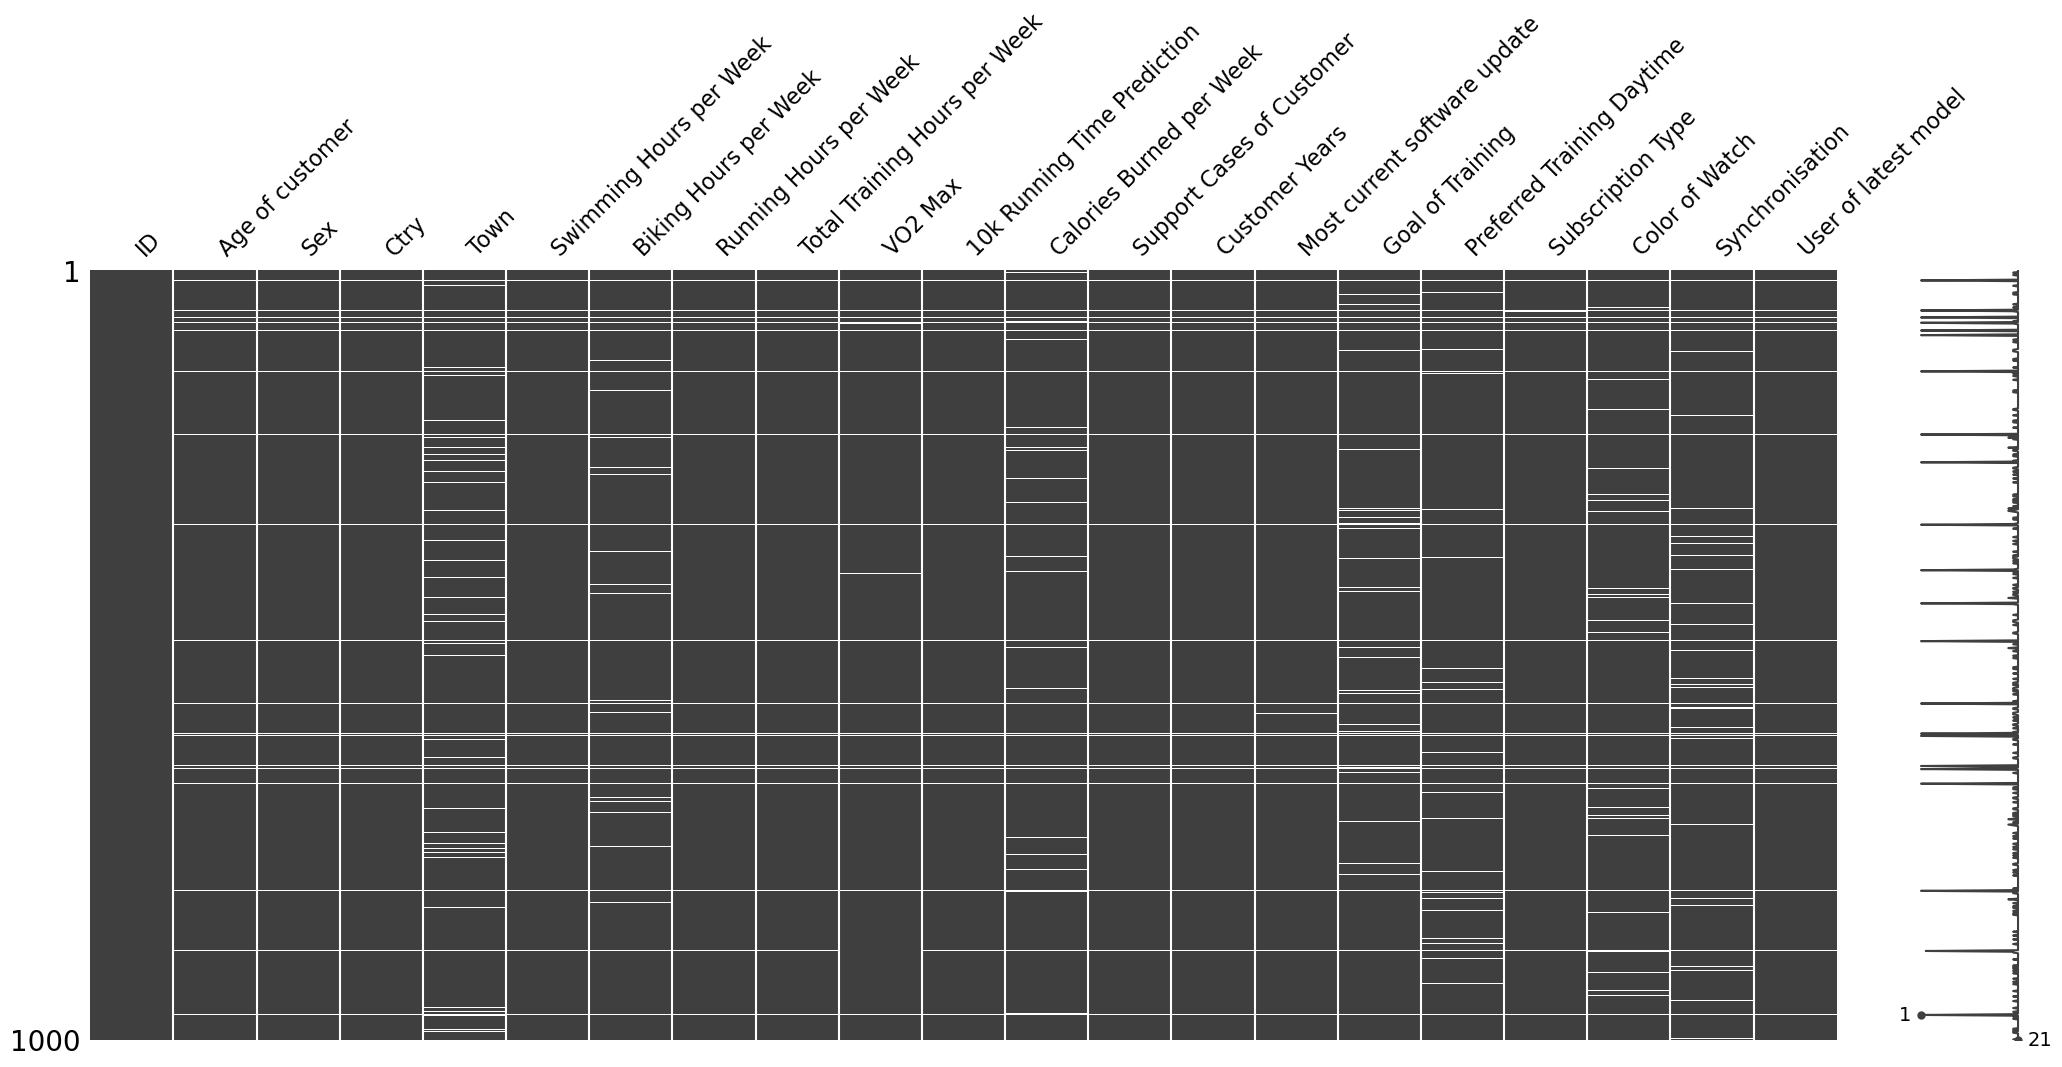

In [19]:
msno.matrix(df)

#### Fehelende IDs werden ersetzt
Wir können die fehlenden IDs mit fortlaufenden Nummern ab C1001 auffüllen
Dies behält die Konsistenz des Benennungsschemas bei
Die neuen IDs überschneiden sich nicht mit bestehenden IDs
Jeder Datensatz erhält eine eindeutige Kennung. Liest die vorhandenen Daten ein
Findet die höchste existierende ID-Nummer
Generiert neue, fortlaufende IDs für fehlende Einträge
Behält alle anderen Daten unverändert bei
Speichert die vervollständigten Daten

In [9]:
import pandas as pd

def complete_missing_ids(df):
    # Höchste vorhandene ID-Nummer finden
    existing_ids = df['ID'].dropna()
    max_number = max([int(id_str[1:]) for id_str in existing_ids if isinstance(id_str, str)])
    
    # Neue IDs generieren
    next_number = max_number + 1
    
    # Fehlende IDs auffüllen
    for idx in df.index:
        if pd.isna(df.at[idx, 'ID']) or df.at[idx, 'ID'] == "":
            df.at[idx, 'ID'] = f'C{str(next_number).zfill(4)}'
            next_number += 1
    
    return df



In [23]:
# Verwendung:
df = complete_missing_ids(df)


<Axes: >

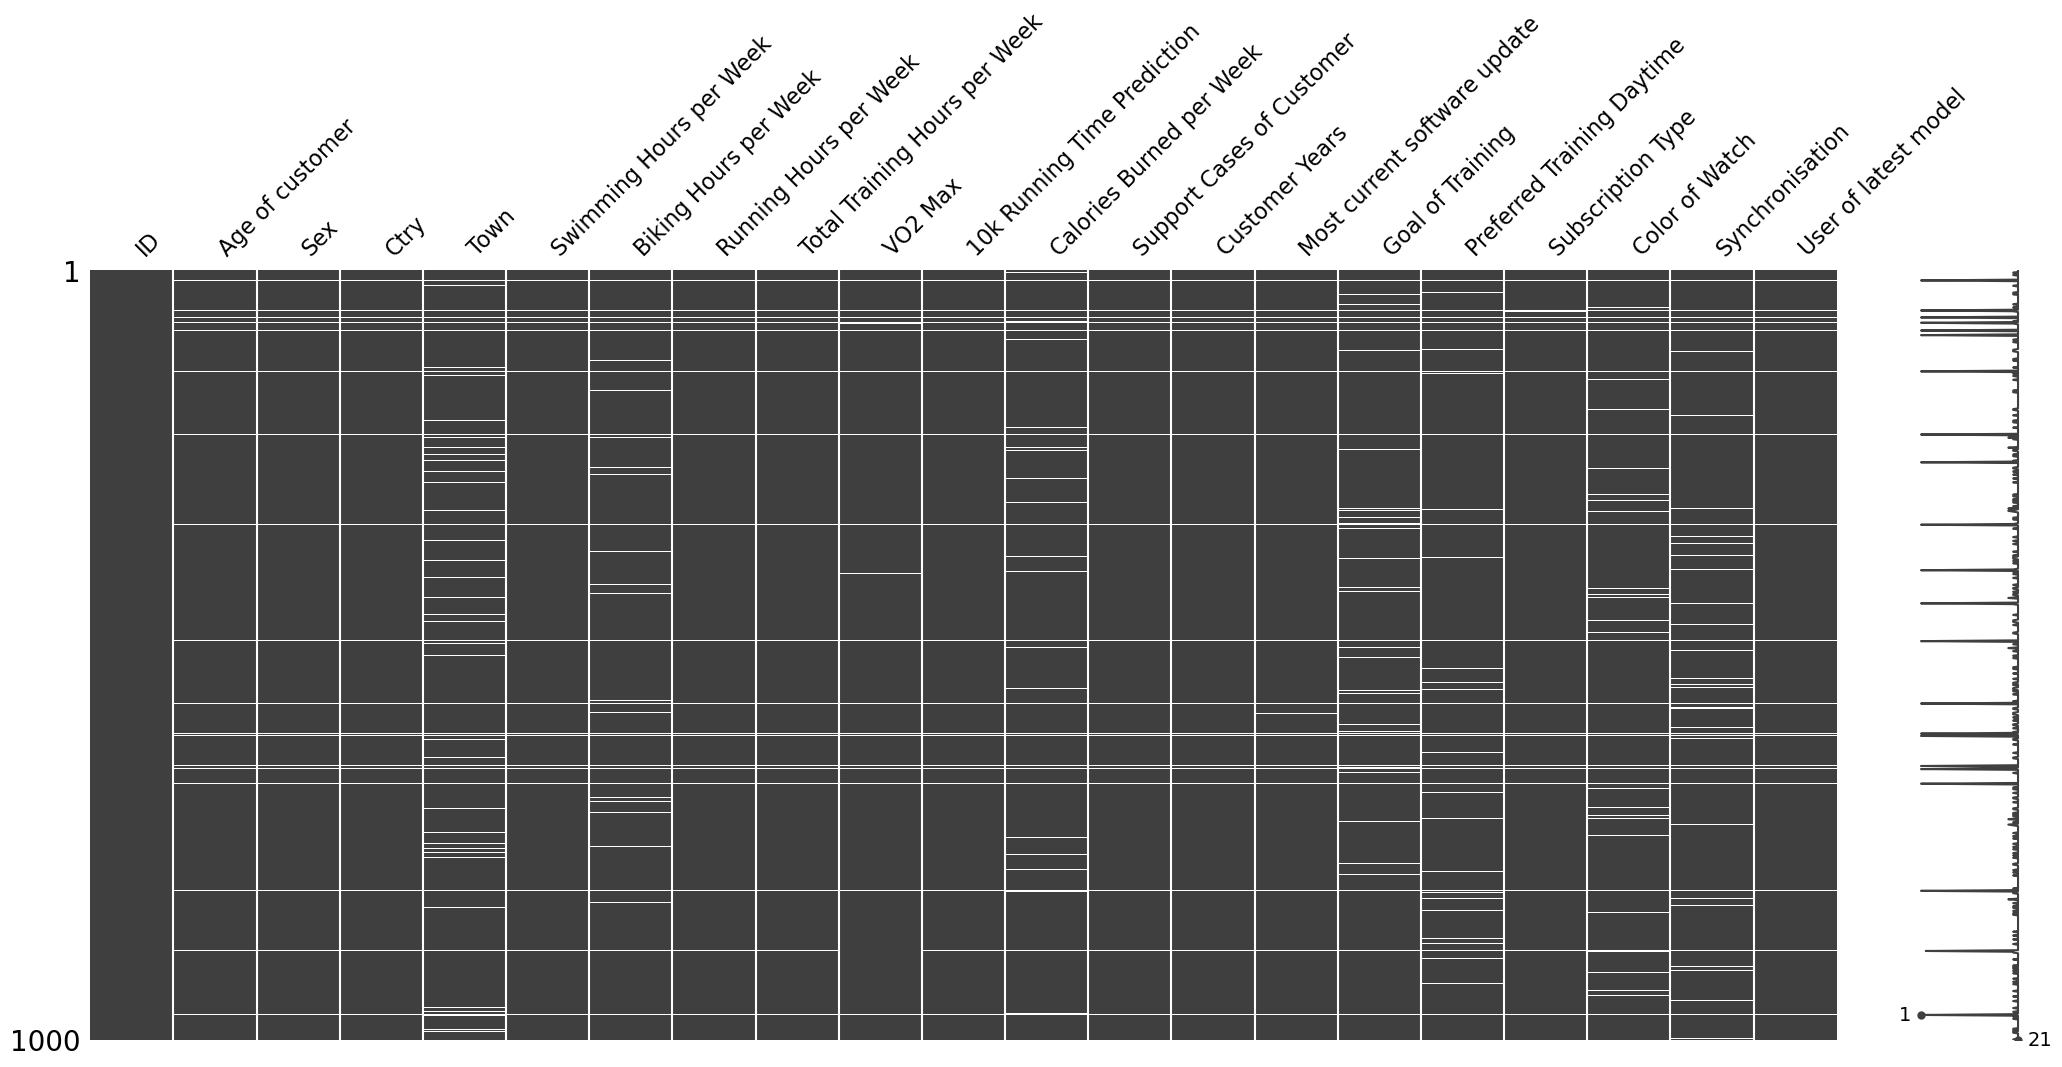

In [24]:
msno.matrix(df)

In [18]:
# Analyse der Städte
print("Anzahl unterschiedlicher Städte:")
print(df['Town'].nunique())

print("\nHäufigkeiten der Städte:")
town_counts = df['Town'].value_counts()
print(town_counts)

print("\nAnteil fehlender Werte:")
missing_percentage = (df['Town'].isnull().sum() / len(df)) * 100
print(f"{missing_percentage:.2f}%")

# Optional: Top 10 häufigste Städte als Prozentsatz
print("\nTop 10 häufigste Städte (Prozentual):")
top_10_percentage = (town_counts.head(10) / len(df)) * 100
print(top_10_percentage)

Anzahl unterschiedlicher Städte:
15

Häufigkeiten der Städte:
Town
Berlin         76
New York       72
Birmingham     70
Melbourne      70
Bangalore      64
Chicago        64
Brisbane       63
Sydney         60
Munich         60
Mumbai         59
Hamburg        59
Manchester     58
Delhi          56
Los Angeles    56
London         52
Name: count, dtype: int64

Anteil fehlender Werte:
6.10%

Top 10 häufigste Städte (Prozentual):
Town
Berlin        7.6
New York      7.2
Birmingham    7.0
Melbourne     7.0
Bangalore     6.4
Chicago       6.4
Brisbane      6.3
Sydney        6.0
Munich        6.0
Mumbai        5.9
Name: count, dtype: float64


In [20]:
# Gruppierung der Städte nach Größenordnung
def categorize_towns(df):
    town_counts = df['Town'].value_counts()
    
    # Dictionary für die Kategorisierung
    categories = {
        'Große Städte (>50 Einträge)': [],
        'Mittlere Städte (20-50 Einträge)': [],
        'Kleine Städte (5-19 Einträge)': [],
        'Sehr kleine Städte (<5 Einträge)': []
    }
    
    for town, count in town_counts.items():
        if count > 50:
            categories['Große Städte (>50 Einträge)'].append(town)
        elif count >= 20:
            categories['Mittlere Städte (20-50 Einträge)'].append(town)
        elif count >= 5:
            categories['Kleine Städte (5-19 Einträge)'].append(town)
        else:
            categories['Sehr kleine Städte (<5 Einträge)'].append(town)
    
    print("Verteilung der Städte nach Größenordnung:")
    for category, towns in categories.items():
        print(f"\n{category}:")
        print(f"Anzahl Städte: {len(towns)}")
        if len(towns) > 0:
            print("Beispiele:", ", ".join(towns[:5]))
            total_entries = sum(town_counts[town] for town in towns)
            print(f"Gesamtanzahl Einträge: {total_entries}")
            print(f"Prozent der Gesamtdaten: {(total_entries/len(df))*100:.2f}%")

categorize_towns(df)

Verteilung der Städte nach Größenordnung:

Große Städte (>50 Einträge):
Anzahl Städte: 15
Beispiele: Berlin, New York, Birmingham, Melbourne, Bangalore
Gesamtanzahl Einträge: 939
Prozent der Gesamtdaten: 93.90%

Mittlere Städte (20-50 Einträge):
Anzahl Städte: 0

Kleine Städte (5-19 Einträge):
Anzahl Städte: 0

Sehr kleine Städte (<5 Einträge):
Anzahl Städte: 0


In [21]:
# Analyse fehlender Werte für Land und Stadt
print("Absolute Anzahl fehlender Werte:")
print(f"Fehlende Länder: {df['Ctry'].isnull().sum()}")
print(f"Fehlende Städte: {df['Town'].isnull().sum()}")

print("\nProzentsatz fehlender Werte:")
print(f"Fehlende Länder: {(df['Ctry'].isnull().sum() / len(df)) * 100:.2f}%")
print(f"Fehlende Städte: {(df['Town'].isnull().sum() / len(df)) * 100:.2f}%")

# Überprüfen, ob es Datensätze gibt, bei denen beides fehlt
both_missing = df[df['Ctry'].isnull() & df['Town'].isnull()]
print(f"\nDatensätze mit fehlenden Werten in beiden Spalten: {len(both_missing)}")

# Überprüfen, ob es Datensätze gibt, wo nur Stadt oder nur Land fehlt
only_country_missing = df[df['Ctry'].isnull() & df['Town'].notnull()]
only_town_missing = df[df['Ctry'].notnull() & df['Town'].isnull()]

print(f"\nDatensätze mit nur fehlendem Land: {len(only_country_missing)}")
print(f"Datensätze mit nur fehlender Stadt: {len(only_town_missing)}")

# Wenn es Fälle gibt, wo nur eines fehlt, diese anzeigen
if len(only_town_missing) > 0:
    print("\nBeispiele für Datensätze mit vorhandenem Land aber fehlender Stadt:")
    print(only_town_missing[['Ctry', 'Town']].head())

if len(only_country_missing) > 0:
    print("\nBeispiele für Datensätze mit vorhandener Stadt aber fehlendem Land:")
    print(only_country_missing[['Ctry', 'Town']].head())

Absolute Anzahl fehlender Werte:
Fehlende Länder: 22
Fehlende Städte: 61

Prozentsatz fehlender Werte:
Fehlende Länder: 2.20%
Fehlende Städte: 6.10%

Datensätze mit fehlenden Werten in beiden Spalten: 22

Datensätze mit nur fehlendem Land: 0
Datensätze mit nur fehlender Stadt: 39

Beispiele für Datensätze mit vorhandenem Land aber fehlender Stadt:
          Ctry Town
6           UK  NaN
20       India  NaN
126  Australia  NaN
137         UK  NaN
195         UK  NaN


In [22]:
# Analyse der Länderverteilung
print("Verteilung der Länder:")
country_counts = df['Ctry'].value_counts()
print(country_counts)

print("\nProzentuale Verteilung der Länder:")
country_percentage = (country_counts / len(df)) * 100
print(country_percentage)

# Prüfen, ob es Städte gibt, die in verschiedenen Ländern vorkommen
cities_multiple_countries = []
for city in df['Town'].unique():
    if pd.notna(city):  # Nur nicht-null Städte überprüfen
        countries = df[df['Town'] == city]['Ctry'].unique()
        if len(countries) > 1:
            cities_multiple_countries.append((city, countries))

if cities_multiple_countries:
    print("\nStädte, die in mehreren Ländern vorkommen:")
    for city, countries in cities_multiple_countries:
        print(f"{city}: {countries}")

Verteilung der Länder:
Ctry
Australia      200
USA            199
UK             191
India          186
Germany        179
Germayn         19
UnknownLand      4
Name: count, dtype: int64

Prozentuale Verteilung der Länder:
Ctry
Australia      20.0
USA            19.9
UK             19.1
India          18.6
Germany        17.9
Germayn         1.9
UnknownLand     0.4
Name: count, dtype: float64

Städte, die in mehreren Ländern vorkommen:
Munich: ['Germany' 'Germayn']
Hamburg: ['Germayn' 'Germany']
London: ['UK' 'UnknownLand']
Berlin: ['Germany' 'Germayn' 'UnknownLand']
Brisbane: ['Australia' 'UnknownLand']


In [27]:
# Analyse der Ländernamen
print("Alle unique Ländernamen:")
# Nur nicht-null Werte betrachten
unique_countries = [country for country in df['Ctry'].unique() if pd.notna(country)]
print(sorted(unique_countries))

# Statistiken zu den Ländern
print("\nStatistiken:")
print(f"Anzahl unterschiedlicher Länder: {len(unique_countries)}")
print(f"Anzahl fehlender Werte (NaN): {df['Ctry'].isnull().sum()}")

# Häufigkeit der Länder
print("\nHäufigkeit der Länder:")
country_counts = df['Ctry'].value_counts(dropna=False)  # dropna=False zeigt auch NaN
print(country_counts)

Alle unique Ländernamen:
['Australia', 'Germany', 'Germayn', 'India', 'UK', 'USA', 'UnknownLand']

Statistiken:
Anzahl unterschiedlicher Länder: 7
Anzahl fehlender Werte (NaN): 22

Häufigkeit der Länder:
Ctry
Australia      200
USA            199
UK             191
India          186
Germany        179
NaN             22
Germayn         19
UnknownLand      4
Name: count, dtype: int64


In [29]:
# Funktion zum Finden ähnlicher Namen
from difflib import get_close_matches

def find_similar_names(names, cutoff=0.8):
    similar_groups = []
    used_names = set()
    
    names = [name for name in names if pd.notna(name)]  # Nur nicht-null Werte
    
    for name in names:
        if name not in used_names:
            matches = get_close_matches(name, names, n=3, cutoff=cutoff)
            if len(matches) > 1:  # Wenn mehr als nur der Name selbst gefunden wurde
                similar_groups.append(matches)
                used_names.update(matches)
    
    return similar_groups

# Ähnliche Ländernamen finden
print("Möglicherweise ähnliche Ländernamen:")
similar_countries = find_similar_names(df['Ctry'].unique())
for group in similar_countries:  # Hier war der Fehler - wir verwenden jetzt similar_countries
    print("\nÄhnliche Namen gefunden:")
    for name in group:
        count = len(df[df['Ctry'] == name])
        print(f"{name}: {count} Vorkommen")

Möglicherweise ähnliche Ländernamen:

Ähnliche Namen gefunden:
Germany: 179 Vorkommen
Germayn: 19 Vorkommen


In [32]:
# Anzahl der "Germayn" Einträge vor der Änderung anzeigen
print("Vor der Korrektur:")
print(df['Ctry'].value_counts()['Germayn'], "Einträge mit 'Germayn'")

# Ersetzen von "Germayn" durch "Germany"
df['Ctry'] = df['Ctry'].replace('Germayn', 'Germany')

# Überprüfen der Änderung
print("\nNach der Korrektur:")
print("Anzahl 'Germany' Einträge:", df['Ctry'].value_counts()['Germany'])
print("Anzahl 'Germayn' Einträge:", 
      df['Ctry'].value_counts()['Germayn'] if 'Germayn' in df['Ctry'].values else 0)

# Zeige die aktualisierten Länder-Counts
print("\nAktualisierte Länderverteilung:")
print(df['Ctry'].value_counts())

Vor der Korrektur:
19 Einträge mit 'Germayn'

Nach der Korrektur:
Anzahl 'Germany' Einträge: 198
Anzahl 'Germayn' Einträge: 0

Aktualisierte Länderverteilung:
Ctry
Australia      200
USA            199
Germany        198
UK             191
India          186
UnknownLand      4
Name: count, dtype: int64


In [34]:
# Datensätze mit UnknownLand finden und anzeigen
unknown_land_entries = df[df['Ctry'] == 'UnknownLand']

print(f"Anzahl der Einträge mit UnknownLand: {len(unknown_land_entries)}")
print("\nDetails dieser Einträge (ID, Land und Stadt):")
print(unknown_land_entries[['ID', 'Ctry', 'Town']])

# Prüfen, ob diese Einträge Städte haben
has_town = unknown_land_entries['Town'].notna().sum()
print(f"\nAnzahl der UnknownLand-Einträge mit Städten: {has_town}")
if has_town > 0:
    print("\nVorhandene Städte für UnknownLand:")
    print(unknown_land_entries['Town'].dropna())

Anzahl der Einträge mit UnknownLand: 4

Details dieser Einträge (ID, Land und Stadt):
        ID         Ctry      Town
146  C0145  UnknownLand    Berlin
470  C0473  UnknownLand    London
757  C0756  UnknownLand  Brisbane
957  C0959  UnknownLand       NaN

Anzahl der UnknownLand-Einträge mit Städten: 3

Vorhandene Städte für UnknownLand:
146      Berlin
470      London
757    Brisbane
Name: Town, dtype: object


In [35]:
# Vor der Änderung
print("UnknownLand Einträge vor der Korrektur:")
print(df[df['Ctry'] == 'UnknownLand'][['ID', 'Ctry', 'Town']])

# Für jede Stadt in UnknownLand-Einträgen das entsprechende Land finden
unknown_entries = df[df['Ctry'] == 'UnknownLand'].copy()

for idx, row in unknown_entries.iterrows():
    if pd.notna(row['Town']):
        # Finde das Land für diese Stadt aus anderen Einträgen
        matching_countries = df[(df['Town'] == row['Town']) & (df['Ctry'] != 'UnknownLand')]['Ctry'].unique()
        
        if len(matching_countries) > 0:
            # Wenn ein eindeutiges Land gefunden wurde
            new_country = matching_countries[0]
            df.loc[idx, 'Ctry'] = new_country
            print(f"\nKorrektur für ID {row['ID']}:")
            print(f"Stadt: {row['Town']} -> Land: {new_country}")

# Nach der Änderung
print("\nVerbleibende UnknownLand Einträge nach der Korrektur:")
print(df[df['Ctry'] == 'UnknownLand'][['ID', 'Ctry', 'Town']])

# Zusammenfassung der Änderungen
print("\nZusammenfassung:")
print(f"Anzahl UnknownLand Einträge: {len(df[df['Ctry'] == 'UnknownLand'])}")

UnknownLand Einträge vor der Korrektur:
        ID         Ctry      Town
146  C0145  UnknownLand    Berlin
470  C0473  UnknownLand    London
757  C0756  UnknownLand  Brisbane
957  C0959  UnknownLand       NaN

Korrektur für ID C0145:
Stadt: Berlin -> Land: Germany

Korrektur für ID C0473:
Stadt: London -> Land: UK

Korrektur für ID C0756:
Stadt: Brisbane -> Land: Australia

Verbleibende UnknownLand Einträge nach der Korrektur:
        ID         Ctry Town
957  C0959  UnknownLand  NaN

Zusammenfassung:
Anzahl UnknownLand Einträge: 1


In [38]:
# Analysiere Länder mit fehlenden Städten
countries_missing_cities = df[df['Town'].isna()]['Ctry'].value_counts()

print("Länder mit fehlenden Städten:")
print(countries_missing_cities)
print(f"\nGesamtanzahl fehlender Städte: {df['Town'].isna().sum()}")

# Analyse der vorhandenen Städte pro Land
print("\nAnzahl unterschiedlicher Städte pro Land:")
cities_per_country = df.groupby('Ctry')['Town'].nunique().sort_values(ascending=False)
print(cities_per_country)

# Detaillierte Auflistung der Städte pro Land
print("\nDetailauflistung der Städte für jedes Land mit fehlenden Städten:")
for country in countries_missing_cities.index:
    cities = df[df['Ctry'] == country]['Town'].unique()
    cities = [city for city in cities if pd.notna(city)]  # Nur nicht-null Städte
    print(f"\n{country}:")
    print(f"Anzahl verschiedener Städte: {len(cities)}")
    print("Städte:", sorted(cities))

Länder mit fehlenden Städten:
Ctry
UK             12
Australia       8
India           7
USA             7
Germany         4
UnknownLand     1
Name: count, dtype: int64

Gesamtanzahl fehlender Städte: 61

Anzahl unterschiedlicher Städte pro Land:
Ctry
Australia      3
Germany        3
India          3
UK             3
USA            3
UnknownLand    0
Name: Town, dtype: int64

Detailauflistung der Städte für jedes Land mit fehlenden Städten:

UK:
Anzahl verschiedener Städte: 3
Städte: ['Birmingham', 'London', 'Manchester']

Australia:
Anzahl verschiedener Städte: 3
Städte: ['Brisbane', 'Melbourne', 'Sydney']

India:
Anzahl verschiedener Städte: 3
Städte: ['Bangalore', 'Delhi', 'Mumbai']

USA:
Anzahl verschiedener Städte: 3
Städte: ['Chicago', 'Los Angeles', 'New York']

Germany:
Anzahl verschiedener Städte: 3
Städte: ['Berlin', 'Hamburg', 'Munich']

UnknownLand:
Anzahl verschiedener Städte: 0
Städte: []


Erstellt für jedes Land eine Liste der verfügbaren Städte
Identifiziert die Zeilen mit fehlendem Stadtnamen pro Land
Füllt die fehlenden Städte zufällig mit existierenden Städten aus dem jeweiligen Land auf
Zeigt eine Zusammenfassung der Änderungen

In [39]:
# Import für Zufallsauswahl
import numpy as np

# Status vor dem Auffüllen
print("Status vor dem Auffüllen:")
print("Anzahl fehlender Städte:", df['Town'].isna().sum())

# Dictionary mit verfügbaren Städten pro Land erstellen
cities_by_country = {}
for country in df['Ctry'].unique():
    if pd.notna(country):  # Nur für nicht-null Länder
        cities = df[(df['Ctry'] == country) & (df['Town'].notna())]['Town'].unique()
        cities = [city for city in cities if pd.notna(city)]  # Nur nicht-null Städte
        if len(cities) > 0:  # Nur Länder mit verfügbaren Städten
            cities_by_country[country] = cities

# Fehlende Städte auffüllen
for country in cities_by_country.keys():
    # Indizes der Zeilen mit fehlendem Stadtnamen für dieses Land
    missing_indices = df[(df['Ctry'] == country) & (df['Town'].isna())].index
    
    if len(missing_indices) > 0:
        available_cities = cities_by_country[country]
        print(f"\nFülle {len(missing_indices)} fehlende Städte für {country} auf")
        
        # Zufällige Auswahl aus verfügbaren Städten
        for idx in missing_indices:
            random_city = np.random.choice(available_cities)
            df.loc[idx, 'Town'] = random_city

# Status nach dem Auffüllen
print("\nStatus nach dem Auffüllen:")
print("Anzahl verbleibender fehlender Städte:", df['Town'].isna().sum())

# Überprüfung pro Land
print("\nVerbleibende fehlende Städte pro Land:")
missing_cities_by_country = df[df['Town'].isna()]['Ctry'].value_counts()
if len(missing_cities_by_country) > 0:
    print(missing_cities_by_country)
else:
    print("Keine fehlenden Städte mehr")

Status vor dem Auffüllen:
Anzahl fehlender Städte: 61

Fülle 12 fehlende Städte für UK auf

Fülle 8 fehlende Städte für Australia auf

Fülle 7 fehlende Städte für India auf

Fülle 4 fehlende Städte für Germany auf

Fülle 7 fehlende Städte für USA auf

Status nach dem Auffüllen:
Anzahl verbleibender fehlender Städte: 23

Verbleibende fehlende Städte pro Land:
Ctry
UnknownLand    1
Name: count, dtype: int64


Identifiziert alle Zeilen, die weder Stadt noch Land haben
Berechnet die Gewichtung der Länder basierend auf ihrer Häufigkeit
Wählt für jede leere Zeile zufällig ein Land basierend auf dieser Gewichtung
Berechnet dann für das gewählte Land die Gewichtung der Städte
Wählt eine Stadt basierend auf der Städtegewichtung
Zeigt zur Kontrolle die Verteilungen vor und nach der Änderung

In [44]:
# Finde Zeilen ohne Stadt und Land
missing_both = df[df['Ctry'].isna() & df['Town'].isna()]
print(f"Anzahl Zeilen ohne Stadt und Land: {len(missing_both)}")

# 1. Länderverteilung berechnen
country_weights = df['Ctry'].value_counts(normalize=True)
print("\nGewichtung der Länder:")
print(country_weights)

# Länder nach Gewichtung zuweisen
for idx in missing_both.index:
    # Zufällige Auswahl eines Landes basierend auf der Gewichtung
    selected_country = np.random.choice(country_weights.index, p=country_weights.values)
    df.loc[idx, 'Ctry'] = selected_country
    
    # Städteverteilung für das ausgewählte Land berechnen
    city_weights = df[df['Ctry'] == selected_country]['Town'].value_counts(normalize=True)
    
    # Zufällige Auswahl einer Stadt basierend auf der Gewichtung
    if len(city_weights) > 0:
        selected_city = np.random.choice(city_weights.index, p=city_weights.values)
        df.loc[idx, 'Town'] = selected_city

print("\nNach der Verteilung:")
print("Verbleibende Zeilen ohne Land:", df['Ctry'].isna().sum())
print("Verbleibende Zeilen ohne Stadt:", df['Town'].isna().sum())

# Überprüfung der neuen Verteilung
print("\nNeue Länderverteilung:")
print(df['Ctry'].value_counts(normalize=True))

# Beispiel für ein spezifisches Land
sample_country = df['Ctry'].value_counts().index[0]
print(f"\nBeispiel Städteverteilung für {sample_country}:")
print(df[df['Ctry'] == sample_country]['Town'].value_counts(normalize=True).head())

Anzahl Zeilen ohne Stadt und Land: 22

Gewichtung der Länder:
Ctry
Australia      0.205521
Germany        0.203476
USA            0.203476
UK             0.196319
India          0.190184
UnknownLand    0.001022
Name: proportion, dtype: float64

Nach der Verteilung:
Verbleibende Zeilen ohne Land: 0
Verbleibende Zeilen ohne Stadt: 1

Neue Länderverteilung:
Ctry
Australia      0.209
USA            0.202
Germany        0.201
UK             0.197
India          0.190
UnknownLand    0.001
Name: proportion, dtype: float64

Beispiel Städteverteilung für Australia:
Town
Melbourne    0.373206
Sydney       0.315789
Brisbane     0.311005
Name: proportion, dtype: float64


In [ ]:
# Finde die Zeile ohne Stadt
missing_city = df[df['Town'].isna()]

print("Zeile ohne Stadt:")
print("\nVollständige Zeileninformationen:")
print(missing_city)

In [47]:
# Speichern des modifizierten DataFrames
output_path = '../Data/triathlon_watch_training_data_modifiziert_ID_Ctry_Town.csv'

# DataFrame in CSV speichern
df.to_csv(output_path, index=False)

# Überprüfung
print(f"DataFrame wurde gespeichert unter: {output_path}")
print(f"Anzahl der Zeilen: {len(df)}")
print(f"Anzahl der Spalten: {len(df.columns)}")
print("\nÜberprüfung auf fehlende Werte in Stadt und Land:")
print("Fehlende Städte:", df['Town'].isna().sum())
print("Fehlende Länder:", df['Ctry'].isna().sum())

DataFrame wurde gespeichert unter: ../Data/triathlon_watch_training_data_modifiziert_ID_Ctry_Town.csv
Anzahl der Zeilen: 1000
Anzahl der Spalten: 21

Überprüfung auf fehlende Werte in Stadt und Land:
Fehlende Städte: 1
Fehlende Länder: 0


<Axes: >

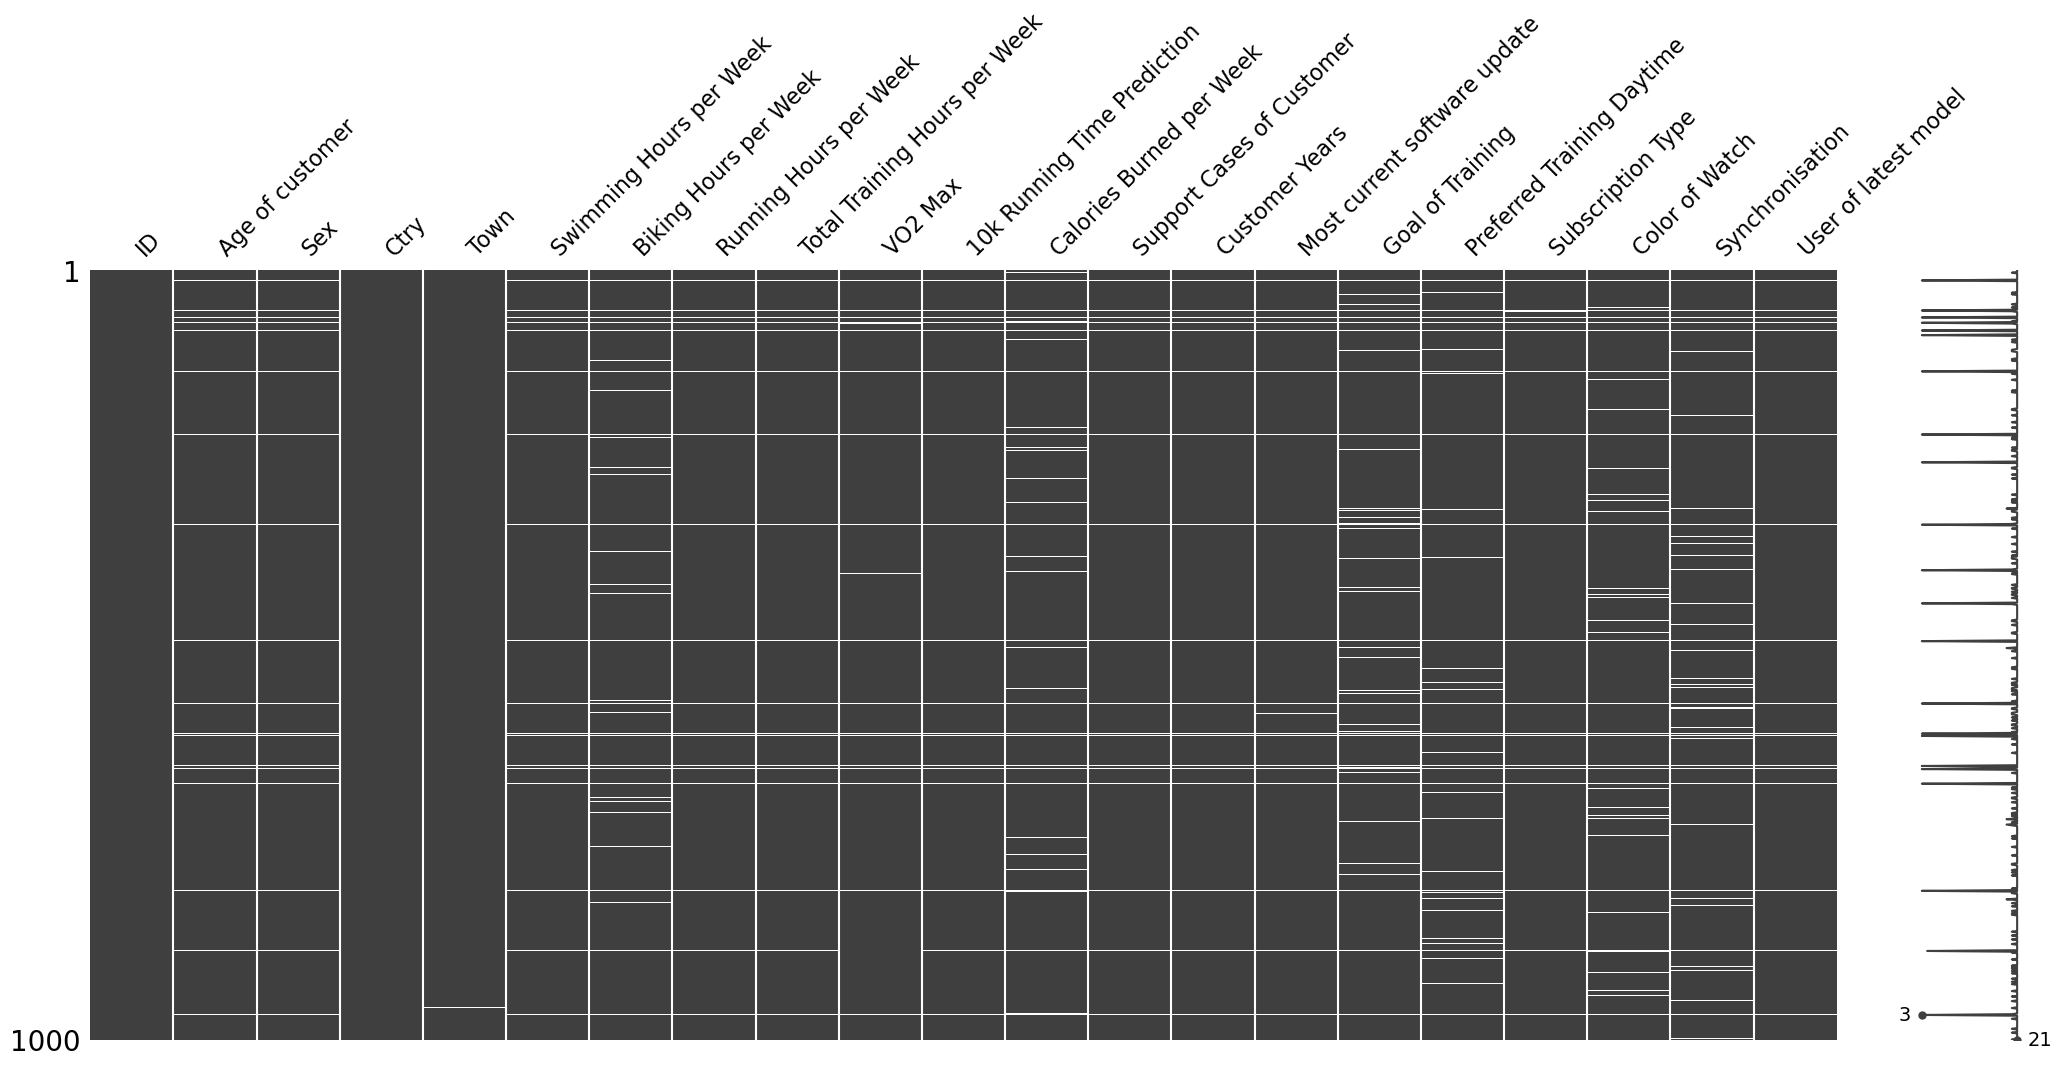

In [3]:
df = pd.read_csv('../Data/triathlon_watch_training_data_modifiziert_ID_Ctry_Town.csv')
msno.matrix(df)